In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score

# Seminar 2 - Support Vector Machine

Javier González Otero - 243078

Jordi Guillén González - 253027

David Sánchez Maldonado - 253798

## Part 1 - Data Preparation and EDA

### Load data

In [32]:
# Train data
train_features = pd.read_csv("data/Train_features.csv",header=None)
train_labels = pd.read_csv("data/Train_labels.csv",header=None)
train_skelleton_points = pd.read_csv("data/Train_skelletonpoints.csv",header=None)

# Test data
test_features = pd.read_csv("data/Test_features.csv",header=None)
test_labels = pd.read_csv("data/Test_labels.csv",header=None)

# Poses conversion to human-language
poses = np.array(['wave', 'push', 'crouch', 'sitdown', 'bend'])

### Skelleton points visualization function

In [3]:
def SkelletonPoints(skelleton_coordinates, pose_labels, train_labels):
    '''
    Plots a visualization of a specific skeleton pose using keypoint coordinates and their connections.

    Parameters:
    skelleton_coordinates (pandas.DataFrame): A single-row DataFrame with 36 values:
                                               the first 18 are x-coordinates, the next 18 are y-coordinates.
    pose_labels (list or np.ndarray): List of human-readable pose labels (e.g., ['wave', 'push', ...]).
    train_labels (pandas.DataFrame): DataFrame with integer pose labels (1 to 5) matching pose_labels.

    Returns:
    tuple: (x, y) coordinates of the 18 skeleton keypoints as lists.
    '''

    connections = [
        [0, 1], [1, 2], [2, 3], [3, 4],
        [1, 5], [5, 6], [6, 7],
        [1, 8], [8, 9], [9, 10],
        [1, 11], [11, 12], [12, 13],
        [0, 14], [0, 15], [14, 16], [15, 17],
        [2, 5], [8, 11]
    ]

    x = []
    y = []
    for i in range(skelleton_coordinates.shape[1] - 18):
        x.append(skelleton_coordinates.iloc[0, i])
        y.append(skelleton_coordinates.iloc[0, i + 18])

    coordinates = [[x[i], y[i]] for i in range(18)]

    for i, (x_p, y_p) in enumerate(coordinates):
        plt.plot(y_p, x_p, 'o', color='blue')

    plt.gca().invert_yaxis()
    plt.axis('equal')

    for a, b in connections:
        x1, y1 = coordinates[a]
        x2, y2 = coordinates[b]
        dx, dy = x2 - x1, y2 - y1
        plt.arrow(y1, x1, dy, dx, head_width=0.1, length_includes_head=True, color='red')

   
    pos = skelleton_coordinates.index.to_list()[0]
    pose_index = int(train_labels.iloc[0, pos])
    plt.title('Actual pose: ' + pose_labels[pose_index - 1])


    return x, y

In [4]:
values_skelleton = train_skelleton_points.iloc[:,:36]
random_skelleton_coordinates = values_skelleton.sample(n=1)

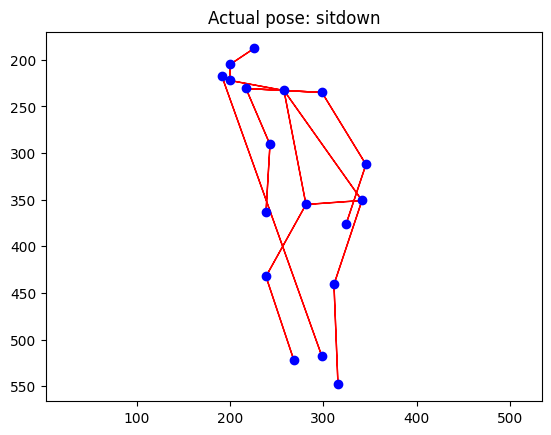

In [5]:
x, y = SkelletonPoints(random_skelleton_coordinates, poses, train_labels)

### Average CSI amplitudes per subcarrier

In [10]:
def plot_csi_amplitude_averages(dataframe, labels, pose_names, sample_index=0):
    '''
    Plots the average CSI amplitude per subcarrier for a given sample and shows its pose label.

    Parameters:
    - dataframe (pd.DataFrame): CSI feature data (270 features per row).
    - labels (pd.DataFrame): Integer labels (1 to 5) for each sample.
    - pose_names (list or np.ndarray): List of human-readable pose names.
    - sample_index (int): Sample to visualize.
    - num_subcarriers (int): Number of subcarriers (default 30).

    Returns:
    - list: Average amplitudes per subcarrier for the selected sample.
    '''

    # Calcular promedio por subportadora
    averages = []
    for j in range(30):
        start = j * 9
        end = start + 9
        csi_block = dataframe.iloc[sample_index, start:end]
        averages.append(np.mean(csi_block))

    # Obtener el nombre de la pose
    pose_index = int(labels.iloc[sample_index, 0]) - 1
    pose_name = pose_names[pose_index]

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.plot(range(30), averages, marker='o', linestyle='-', color='darkorange')
    plt.title(f'CSI amplitude Avg per Subcarrier | Sample {sample_index} | Pose: {pose_name}', fontsize=14, weight='bold')
    plt.xlabel('Subcarrier Index', fontsize=12)
    plt.ylabel('Average CSI Amplitude', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(range(30))
    plt.tight_layout()
    plt.show()

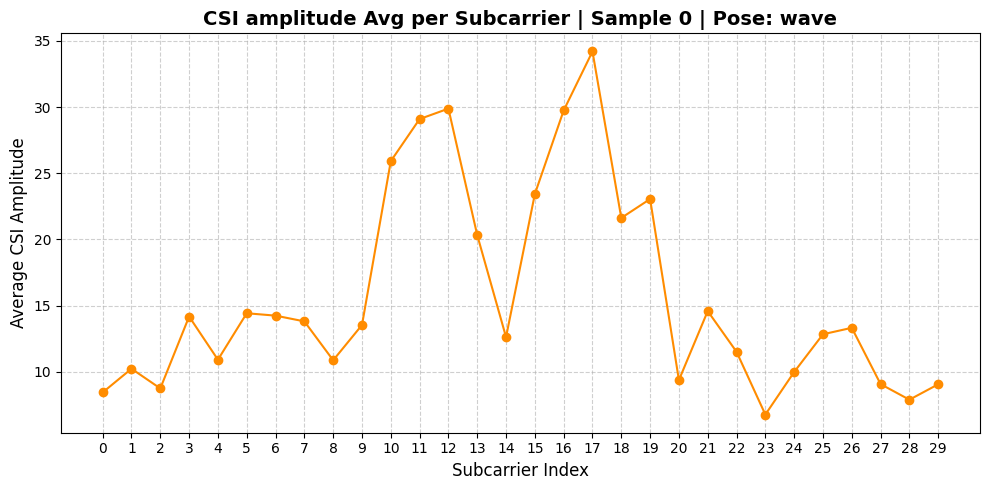

In [12]:
# Plot of the first sample
plot_csi_amplitude_averages(train_features, train_labels, poses, sample_index=0)

### Average CSI Amplitudes per class

In [19]:
def plot_classwise_csi_amplitude_distribution(features, labels, pose_names):
    '''
    Plots the average CSI amplitude per subcarrier for each class (pose).

    Parameters:
    - features (pd.DataFrame): CSI features (270 per sample).
    - labels (pd.DataFrame): Labels from 1 to 5 for each sample.
    - pose_names (list): Human-readable pose labels (e.g., ['wave', 'push', ...]).

    Returns:
    - pd.DataFrame: Averages per class and subcarrier.
    '''

    # Initialize list to store per-class averages
    averages_per_class = [[] for _ in range(len(pose_names))]

    # Compute average per subcarrier for each class
    for class_idx in range(1, 6):  # Classes 1 to 5
        class_samples = train_features[train_labels.iloc[0, :] == class_idx]
        class_averages = []

        for subcarrier in range(30):
            start = subcarrier * 9
            end = start + 9

            # Average the 9 CSI values of the subcarrier (across all antenna pairs)
            avg_amplitudes = class_samples.iloc[:, start:end].mean(axis=1)

            # Compute the average across all samples of this class
            class_averages.append(avg_amplitudes.mean())

        averages_per_class[class_idx - 1] = class_averages

    # Convert to DataFrame for easier handling
    df = pd.DataFrame(averages_per_class, index=pose_names)

    # Plot
    plt.figure(figsize=(12, 6))
    for i, pose in enumerate(pose_names):
        plt.plot(df.columns, df.iloc[i], marker='o', label=pose)

    plt.title("Average CSI Amplitude per Subcarrier by Class", fontsize=14, weight='bold')
    plt.xlabel("Subcarrier Index", fontsize=12)
    plt.ylabel("Average CSI Amplitude", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(range(30))
    plt.legend()
    plt.tight_layout()
    plt.show()

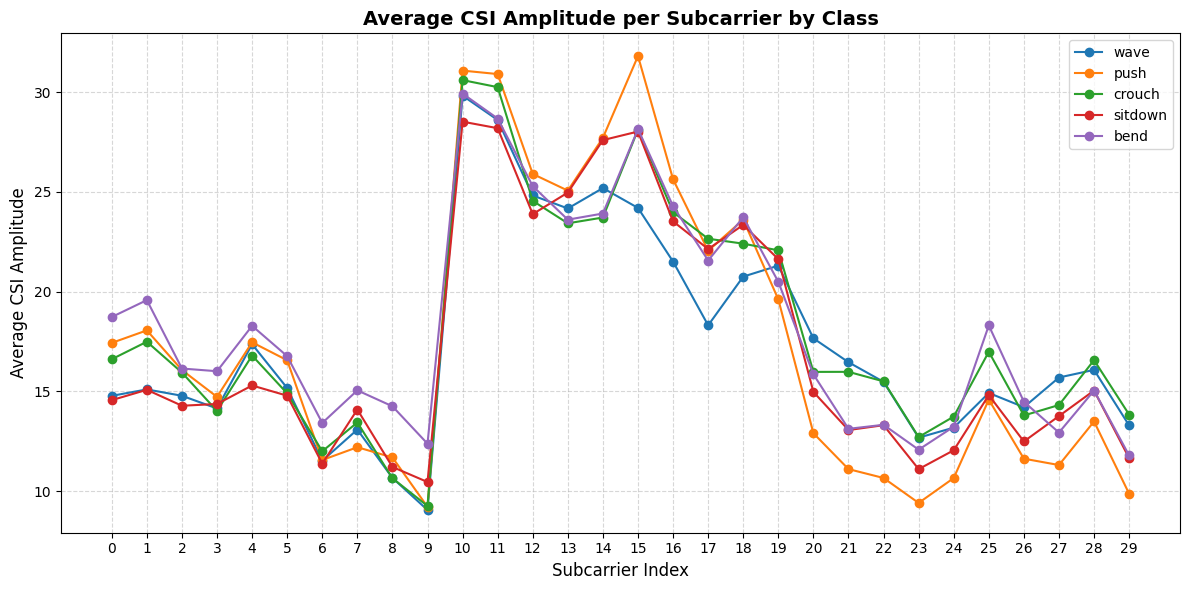

In [20]:
plot_classwise_csi_amplitude_distribution(train_features, train_labels, poses)

## Part 2 - Model Implementation

### SVM module creation and fitting

In [30]:
def train_svm_model(X_train, y_train, kernel='rbf', C=1.0, gamma='scale'):
    '''
    Trains a Support Vector Machine (SVM) classifier on the given CSI feature data.

    Parameters:
    - X_train (pd.DataFrame or np.ndarray): CSI features (shape: [n_samples, 270]).
    - y_train (pd.Series or np.ndarray): Labels (values from 1 to 5).
    - kernel (str): Kernel type ('linear', 'rbf', 'poly', etc.)
    - C (float): Regularization parameter.
    - gamma (str or float): Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.

    Returns:
    - model: Trained SVM model.
    - scaler: StandardScaler used for normalization.
    '''
    # flatten train labels
    y_train = y_train.iloc[0, :].values.ravel()

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    # Train SVM
    svm = SVC(kernel=kernel, C=C, gamma=gamma)
    svm.fit(X_scaled, y_train)

    return svm, scaler

In [31]:
model, scaler = train_svm_model(train_features, train_labels, kernel='rbf', C=10, gamma='scale')

### Generate predictions

In [33]:
def predict_with_svm(model, scaler, X_test):
    '''
    Generates predictions on the test dataset using a trained SVM model.

    Parameters:
    - model: Trained SVM classifier.
    - scaler: StandardScaler used during training.
    - X_test (pd.DataFrame or np.ndarray): Test features.

    Returns:
    - np.ndarray: Predicted labels for the test samples.
    '''
    X_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_scaled)
    return y_pred

In [34]:
pred_labels = predict_with_svm(model, scaler, test_features)

### Evaluation

In [39]:
def evaluate_svm_predictions(y_true, y_pred, pose_labels):
    '''
    Evaluates predictions using classification metrics and confusion matrix.

    Parameters:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels.
    - pose_labels (list): Human-readable class names.

    Outputs:
    - Prints accuracy and classification report.
    - Shows confusion matrix as a heatmap.
    '''
    # flatten test labels
    y_true = y_true.iloc[0, :].values.ravel()

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")

    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=pose_labels))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pose_labels, yticklabels=pose_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

✅ Accuracy: 0.8650

📊 Classification Report:
              precision    recall  f1-score   support

        wave       0.88      0.86      0.87        42
        push       0.83      0.90      0.86        39
      crouch       0.89      0.89      0.89        35
     sitdown       0.91      0.84      0.88        38
        bend       0.83      0.85      0.84        46

    accuracy                           0.86       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.86      0.87       200



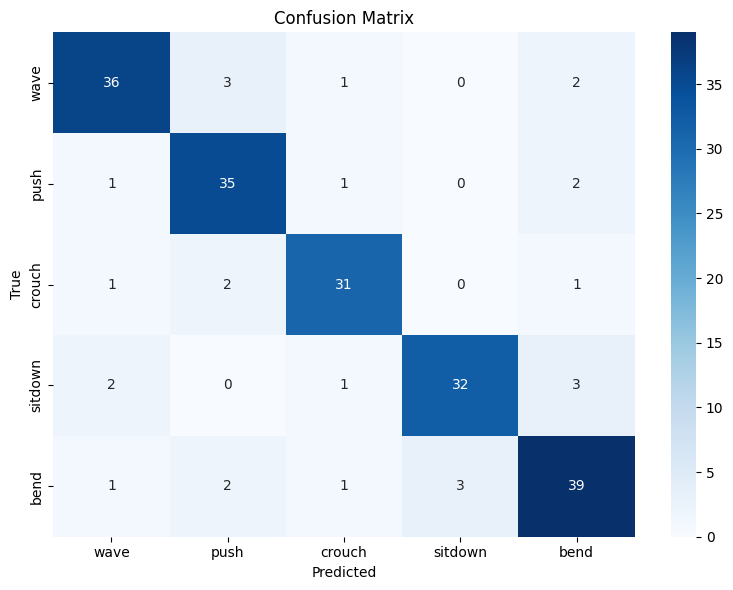

In [40]:
evaluate_svm_predictions(test_labels, pred_labels, poses)